<h1>Introduction</h1>
Megaline provides two different prepaid plans to their users. After users reach the limits of their chosen plan, they are charged per usage. The data provided describes user information, plan information, and the details of metrics of different parts of the plan: messages, internet, and calling. In this analysis, I will look at user behavior in the two different plans to make recommendations about which plan brings in more revenue based on this sample of the client base. 

These are the different libraries that are necessary to complete the analysis.

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from math import factorial


I checked for different delimiters or decimals and found that nothing needed changed.

In [2]:
# Load the data files into different DataFrames
data_calls = pd.read_csv('/datasets/megaline_calls.csv')
data_internet = pd.read_csv('/datasets/megaline_internet.csv')
data_messages = pd.read_csv('/datasets/megaline_messages.csv')
data_plans = pd.read_csv('/datasets/megaline_plans.csv')
data_users = pd.read_csv('/datasets/megaline_users.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/megaline_calls.csv'

Most of the DataFrames needed corrections, and I added columns to every DataFrame.

## Plans

In [ ]:
# Print the general/summary information about the plans' DataFrame
data_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [ ]:
# Print a sample of data for plans
display(data_plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


While this dataset has multiple columns, it only has two rows, which makes sense because there are only two plans available. The datatypes are appropriate and all data is filled in.

## Fix data

There are no obvious issues with this dataset.
Update after completing all work: I still did not need to make any changes to fix this dataset.

## Enrich data

I converted megabytes to gigabytes and added a column to complete future calculations

In [ ]:
data_plans['gb_per_month_included'] = data_plans['mb_per_month_included'] / 1024
display(data_plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.36
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.72


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

We have 1024 Mb in 1 Gb =)
</div>

## Users

In [ ]:
# Print the general/summary information about the users' DataFrame
data_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
# Print a sample of data for users
display(data_users.head())


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Looking at the sample, the city column contains too much information. It has city, state, and "MSA", which is unclear. In looking at the CSV, the city column contains multiple cities sometimes, and multiple states. If this information is going to be used in data analysis, it will need to be separated into different city, state, and "MSA" columns. Whether this is necessary remains to be seen.

The churn date is not always available, which makes sense if the user still has an active plan. However, if there is not a churn date, the column contains a NaN value. This will need to be replaced.

The dates are objects. I will change them into a date datatype.

I have checked for duplicates and changed the reg_date to a date datatype. I left the churn_date alone for the time being.

In [ ]:
print(data_users.duplicated().sum())
print(data_users['user_id'].duplicated().sum())
data_users['firstname_lowercase'] = data_users['first_name'].str.lower()
data_users['lastname_lowercase'] = data_users['last_name'].str.lower()
print(data_users.duplicated(subset=['firstname_lowercase', 'lastname_lowercase']).sum())
data_users['churn_date'] = data_users['churn_date'].fillna(0)
data_users['churn_date'].isna().sum()
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
#data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users.info()                                       

0
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              500 non-null    int64         
 1   first_name           500 non-null    object        
 2   last_name            500 non-null    object        
 3   age                  500 non-null    int64         
 4   city                 500 non-null    object        
 5   reg_date             500 non-null    datetime64[ns]
 6   plan                 500 non-null    object        
 7   churn_date           500 non-null    object        
 8   firstname_lowercase  500 non-null    object        
 9   lastname_lowercase   500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 39.2+ KB


Due to needing to sort data by month, I extracted the month from the date and added a column.

In [ ]:
data_users['month'] = data_users['reg_date'].dt.month
display(data_users.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,firstname_lowercase,lastname_lowercase,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,anamaria,bauer,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,0,mickey,wilkerson,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,0,carlee,hoffman,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,0,reynaldo,jenkins,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,0,leonila,thompson,5


## Calls

In [ ]:
# Print the general/summary information about the calls' DataFrame
data_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
# Print a sample of data for calls
display(data_calls.head())


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


It's a little odd that the "id" column is an object. It looks like the underscore is the reason, but I may try to remove the underscore and convert the datatype to int. I will also need to change the date to a datetime datatype.

I checked for duplicates and converted the call_date to a datetime datatype.

In [ ]:
data_calls['id'] = data_calls['id'].astype('int')

print(data_calls.duplicated().sum())
print(data_calls['id'].duplicated().sum())
print(data_calls.duplicated(subset=['id', 'user_id']).sum())
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')


display(data_calls.head())
data_calls.info()

0
0
0


,id,user_id,call_date,duration
0,100093,1000,2018-12-27,8.52
1,1000145,1000,2018-12-27,13.66
2,1000247,1000,2018-12-27,14.48
3,1000309,1000,2018-12-28,5.76
4,1000380,1000,2018-12-30,4.22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  int64         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.2 MB


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

To be precise we need to round up minutes (np.ceil for example).
</div>

Due to needing to sort data by month, I extracted the month from the date and added a column.

In [ ]:
data_calls['month'] = data_calls['call_date'].dt.month
display(data_calls.head())


,id,user_id,call_date,duration,month
0,100093,1000,2018-12-27,8.52,12
1,1000145,1000,2018-12-27,13.66,12
2,1000247,1000,2018-12-27,14.48,12
3,1000309,1000,2018-12-28,5.76,12
4,1000380,1000,2018-12-30,4.22,12


## Messages

In [ ]:
# Print the general/summary information about the messages' DataFrame
data_messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Print a sample of data for messages
display(data_messages.head())


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


The "id" is an object due to the underscore again. I will need to look at that, and the date as an object as well.

I converted the "id" field to int. I also checked for duplicates again and converted the message_date to the datetime datatype.

In [ ]:
data_messages['id'] = data_messages['id'].astype('int')

print(data_messages.duplicated().sum())
print(data_messages['id'].duplicated().sum())
print(data_messages.duplicated(subset=['id', 'user_id']).sum())
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

display(data_messages.head())
data_messages.info()

0
0
0


,id,user_id,message_date
0,1000125,1000,2018-12-27
1,1000160,1000,2018-12-31
2,1000223,1000,2018-12-31
3,1000251,1000,2018-12-27
4,1000255,1000,2018-12-26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int64         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.7 MB


Due to needing to sort data by month, I extracted the month from the date and added a column.

In [ ]:
data_messages['month'] = data_messages['message_date'].dt.month
display(data_messages.head())


,id,user_id,message_date,month
0,1000125,1000,2018-12-27,12
1,1000160,1000,2018-12-31,12
2,1000223,1000,2018-12-31,12
3,1000251,1000,2018-12-27,12
4,1000255,1000,2018-12-26,12


## Internet

In [ ]:
# Print the general/summary information about the internet DataFrame
data_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [ ]:
# Print a sample of data for the internet traffic
display(data_internet.head())


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Data is charged by the gb and documented by the mb. However, it does not look like large amounts (gigabytes) of data are used. I will need to consider how to analyze this further. As before, "id" and session_date are objects and will need to be converted to int and datetime, respectively.

I converted the id column to int and the session_date column to the datetime datatype. I also checked for duplicates.

In [ ]:
data_internet['id'] = data_internet['id'].astype('int')

print(data_internet.duplicated().sum())
print(data_internet['id'].duplicated().sum())
print(data_internet.duplicated(subset=['id', 'user_id']).sum())
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')


display(data_internet.head())
data_internet.info()

0
0
0


,id,user_id,session_date,mb_used
0,100013,1000,2018-12-29,89.86
1,1000204,1000,2018-12-31,0.00
2,1000379,1000,2018-12-28,660.40
3,1000413,1000,2018-12-26,270.99
4,1000442,1000,2018-12-27,880.22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int64         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.2 MB


Due to needing to sort data by month, I extracted the month from the date and added a column.

In [ ]:
data_internet['month'] = data_internet['session_date'].dt.month
display(data_internet.head())

,id,user_id,session_date,mb_used,month
0,100013,1000,2018-12-29,89.86,12
1,1000204,1000,2018-12-31,0.00,12
2,1000379,1000,2018-12-28,660.40,12
3,1000413,1000,2018-12-26,270.99,12
4,1000442,1000,2018-12-27,880.22,12


I printed out the plan conditions to make sure I had them available readily.

In [ ]:
display(data_plans.head())


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.36
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.72


## Aggregate data per user

I aggregated data by month and user_id and then grouped by id and counted the number of calls. I then added up the total number of minutes per user per month. I did the same thing with the number of messages and the amount of data for the internet usage.

In [ ]:
# Calculate the number of calls made by each user per month. Save the result.
grp = data_calls.groupby(['user_id', 'month'])
call_sum = grp['id'].count()
print(call_sum)



user_id  month
1000     12       16
1001     8        27
         9        49
         10       65
         11       64
                  ..
1498     12       39
1499     9        41
         10       53
         11       45
         12       65
Name: id, Length: 2258, dtype: int64


In [ ]:
# Calculate the amount of minutes spent by each user per month. Save the result.
total_minutes = grp['duration'].sum()
print(total_minutes)

user_id  month
1000     12       116.83
1001     8        171.14
         9        297.69
         10       374.11
         11       404.59
                   ...  
1498     12       324.77
1499     9        330.37
         10       363.28
         11       288.56
         12       468.10
Name: duration, Length: 2258, dtype: float64


In [ ]:
# Calculate the number of messages sent by each user per month. Save the result.
grp1 = data_messages.groupby(['user_id', 'month'])
user_messages = grp1['id'].count()
print(user_messages)


user_id  month
1000     12       11
1001     8        30
         9        44
         10       53
         11       36
                  ..
1496     9        21
         10       18
         11       13
         12       11
1497     12       50
Name: id, Length: 1806, dtype: int64


In [ ]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
#display(data_internet.head())
grp2 = data_internet.groupby(['user_id', 'month'])
internet_traffic = grp2['mb_used'].sum()
print(internet_traffic)

user_id  month
1000     12        1901.47
1001     8         6919.15
         9        13314.82
         10       22330.49
         11       18504.30
                    ...   
1498     12       23137.69
1499     9        12984.76
         10       19492.43
         11       16813.83
         12       22059.21
Name: mb_used, Length: 2277, dtype: float64


I concatenated all the data together and reset the index so that the user ID and month would be included as columns instead. I then merged the user_info DataFrame and dropped the irrelevant columns so that the plan information was part of the new DataFrame as well. I noticed that a couple of columns were missing data that could be filled in with zeroes, so I did that and converted certain columns to an int datatype, as they would not have decimals. I also added a region column in preparation for testing the final hypothesis.

In [ ]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_info = pd.concat([call_sum, total_minutes, user_messages, internet_traffic],axis='columns')
user_info.columns= ['number_calls', 'total_minutes', 'total_messages', 'internet_traffic']
user_info.reset_index(inplace=True)
print(user_info)


      user_id  month  number_calls  total_minutes  total_messages  \
0        1000     12          16.0         116.83            11.0   
1        1001      8          27.0         171.14            30.0   
2        1001      9          49.0         297.69            44.0   
3        1001     10          65.0         374.11            53.0   
4        1001     11          64.0         404.59            36.0   
...       ...    ...           ...            ...             ...   
2288     1498     12          39.0         324.77             NaN   
2289     1499      9          41.0         330.37             NaN   
2290     1499     10          53.0         363.28             NaN   
2291     1499     11          45.0         288.56             NaN   
2292     1499     12          65.0         468.10             NaN   

      internet_traffic  
0              1901.47  
1              6919.15  
2             13314.82  
3             22330.49  
4             18504.30  
...                ..

In [ ]:
# Add the plan information
updated_user_info = user_info.merge(data_users, on='user_id')
updated_user_info = updated_user_info.drop(['first_name', 
                                            'last_name', 
                                            'age', 
                                            'city',
                                            'reg_date',
                                            'churn_date',
                                            'firstname_lowercase',
                                            'lastname_lowercase',
                                            'month_y'], 
                                             axis='columns')
updated_user_info.info()
display(updated_user_info.head())
for index, row in data_users.iterrows():
    if 'NY' or 'NJ' in row['city']:
        updated_user_info.loc[index, 'region'] = 'NY-NJ'
        #updated_user_info['region'] = 'NY-NJ'
    else:
        updated_user_info.loc[index, 'region'] = 'N/A'
    

print(updated_user_info[updated_user_info['region'] == 'NY-NJ'].count())    

updated_user_info['number_calls'] = updated_user_info['number_calls'].fillna(0)
updated_user_info['total_minutes'] = updated_user_info['total_minutes'].fillna(0)
updated_user_info['total_messages'] = updated_user_info['total_messages'].fillna(0)
updated_user_info['internet_traffic'] = updated_user_info['internet_traffic'].fillna(0)
updated_user_info['region'] = updated_user_info['region'].fillna('None')

updated_user_info['number_calls'] = updated_user_info['number_calls'].astype('int')
updated_user_info['total_messages'] = updated_user_info['total_messages'].astype('int')
updated_user_info['internet_traffic_gb'] = updated_user_info['internet_traffic'] / 1000

updated_user_info.info()
display(updated_user_info.sample(25))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2293 non-null   int64  
 1   month_x           2293 non-null   int64  
 2   number_calls      2258 non-null   float64
 3   total_minutes     2258 non-null   float64
 4   total_messages    1806 non-null   float64
 5   internet_traffic  2277 non-null   float64
 6   plan              2293 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 143.3+ KB


,user_id,month_x,number_calls,total_minutes,total_messages,internet_traffic,plan
0,1000,12,16.0,116.83,11.0,1901.47,ultimate
1,1001,8,27.0,171.14,30.0,6919.15,surf
2,1001,9,49.0,297.69,44.0,13314.82,surf
3,1001,10,65.0,374.11,53.0,22330.49,surf
4,1001,11,64.0,404.59,36.0,18504.30,surf


user_id             500
month_x             500
number_calls        493
total_minutes       493
total_messages      378
internet_traffic    499
plan                500
region              500
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2293 non-null   int64  
 1   month_x              2293 non-null   int64  
 2   number_calls         2293 non-null   int64  
 3   total_minutes        2293 non-null   float64
 4   total_messages       2293 non-null   int64  
 5   internet_traffic     2293 non-null   float64
 6   plan                 2293 non-null   object 
 7   region               2293 non-null   object 
 8   internet_traffic_gb  2293 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 243.7+ KB


,user_id,month_x,number_calls,total_minutes,total_messages,internet_traffic,plan,region,internet_traffic_gb
951,1197,11,88,566.13,11,11032.60,surf,None,11.03260
1345,1290,11,18,97.91,50,8938.66,surf,None,8.93866
264,1060,10,98,643.38,74,24445.77,surf,NY-NJ,24.44577
288,1064,6,24,142.45,3,6572.23,surf,NY-NJ,6.57223
7,1002,11,55,359.76,32,19345.08,surf,NY-NJ,19.34508
1268,1265,12,40,196.17,0,28051.14,surf,None,28.05114
555,1117,12,40,288.11,0,25026.19,surf,None,25.02619
124,1033,12,98,552.76,32,21003.90,ultimate,NY-NJ,21.00390
29,1009,5,71,498.93,0,20389.40,surf,NY-NJ,20.38940
1505,1328,5,104,787.01,149,30365.39,surf,None,30.36539


For each plan, I calculated the total revenue based on the plan information. If the "revenue" wound up being a negative number, I replaced it with a zero. After these calculations, I added the base price to the total.

In [ ]:
# Calculate the monthly revenue for each user
#display(updated_user_info['plan'].head(25))
updated_user_info['revenue'] = 0
#ultimate_revenue = updated_user_info[updated_user_info['plan'] == 'ultimate']
#surf_revenue = updated_user_info[updated_user_info['plan'] == 'surf']
#print(ultimate_revenue)
if (updated_user_info['plan'].isin(['ultimate'])).any():
    updated_user_info['revenue'] = ((updated_user_info['total_messages'] - 1000) * 0.01) + ((updated_user_info['total_minutes'] - 3000) * 0.01) + ((updated_user_info['internet_traffic_gb'] - 30.72) * 7)
elif (updated_user_info['plan'].isin(['surf'])).any():
    updated_user_info['revenue'] = ((updated_user_info['total_messages'] - 50) * 0.03) + ((updated_user_info['total_minutes'] - 500) * 0.03) + ((updated_user_info['internet_traffic_gb'] - 15.36) * 10)   
else:
    print('No plan listed! Check again')
#print(updated_user_info['plan'].isin(['ultimate'])).any()

updated_user_info['revenue'] = updated_user_info['revenue'].where((updated_user_info['revenue'] > 0), 0) 


updated_user_info['revenue'] = updated_user_info['revenue'].where((updated_user_info['plan'] != 'ultimate'), updated_user_info['revenue'] + 70)        
updated_user_info['revenue'] = updated_user_info['revenue'].where((updated_user_info['plan'] != 'surf'), updated_user_info['revenue'] + 20)        
                                                                                       
        
display(updated_user_info.sample(25))

,user_id,month_x,number_calls,total_minutes,total_messages,internet_traffic,plan,region,internet_traffic_gb,revenue
528,1111,12,38,342.26,92,14857.96,surf,None,14.85796,20.0
1926,1411,8,39,239.84,0,8987.55,surf,None,8.98755,20.0
1579,1341,11,91,653.24,75,22828.85,surf,None,22.82885,20.0
739,1155,7,24,130.26,27,20407.80,ultimate,None,20.40780,70.0
179,1044,12,39,295.03,31,15473.81,surf,NY-NJ,15.47381,20.0
2078,1448,11,36,224.46,55,12481.52,surf,None,12.48152,20.0
1049,1220,8,66,544.35,33,24289.51,surf,None,24.28951,20.0
831,1173,9,10,68.98,9,409.43,surf,None,0.40943,20.0
1180,1251,7,88,548.64,39,22913.54,surf,None,22.91354,20.0
275,1061,12,83,496.63,93,23815.85,ultimate,NY-NJ,23.81585,70.0


## Study user behaviour

I created a variable that has the new DataFrame grouped by month and plan. That variable is used frequently throughout the analysis. 

First I calculated average duration by using the sum of total minutes and the sum of the number of calls. I then used those averages to create a bar chart. There was very little difference in between the average monthly call duration between the two plans; all the averages were between six and seven minutes.

### Calls

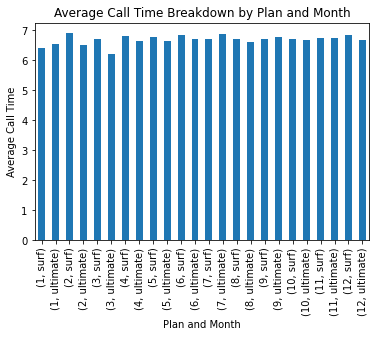

month_x  plan    
1        surf        6.428000
         ultimate    6.541518
2        surf        6.906175
         ultimate    6.517230
3        surf        6.696919
         ultimate    6.210906
4        surf        6.799918
         ultimate    6.659990
5        surf        6.769200
         ultimate    6.662443
6        surf        6.846812
         ultimate    6.705188
7        surf        6.721710
         ultimate    6.879085
8        surf        6.726164
         ultimate    6.613484
9        surf        6.728684
         ultimate    6.770040
10       surf        6.722302
         ultimate    6.665850
11       surf        6.759115
         ultimate    6.742506
12       surf        6.836607
         ultimate    6.671929
dtype: float64


In [ ]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
grp3 = updated_user_info.groupby(['month_x', 'plan'])
avg_duration = grp3['total_minutes'].sum() / grp3['number_calls'].sum()
avg_duration.plot(kind='bar',
                  x=['month_x', 'plan'],
                  y='total_minutes',
                  title='Average Call Time Breakdown by Plan and Month',
                  xlabel='Plan and Month',
                  ylabel='Average Call Time'
                  )

plt.show()
print(avg_duration)

I filtered the data by plan, then grouped by month. After that, I calculated the total number of minutes each plan required for each month and plotted them onto a histogram. The surf plan had a wider distribution than the ultimate plan.

<AxesSubplot:ylabel='Frequency'>

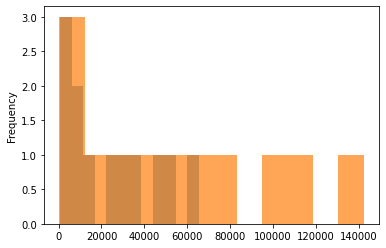

In [ ]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

monthly_ultimate_minutes = (updated_user_info[updated_user_info['plan'] == 'ultimate']).groupby('month_x')['total_minutes'].sum()


monthly_ultimate_minutes.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)

monthly_surf_minutes = (updated_user_info[updated_user_info['plan'] == 'surf']).groupby('month_x')['total_minutes'].sum()


monthly_surf_minutes.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)


I filtered the data by plan, then grouped by month. First I calculated average duration by using the sum of total minutes and the sum of the number of calls. I then calculated the variance as well using both total minutes and the number of calls, though I am less confident about that calculation.

In [ ]:
# Calculate the mean and the variance of the monthly call duration
monthly_ultimate = (updated_user_info[updated_user_info['plan'] == 'ultimate']).groupby('month_x')
monthly_surf = (updated_user_info[updated_user_info['plan'] == 'surf']).groupby('month_x')
ultimate_mean = monthly_ultimate['total_minutes'].sum() / monthly_ultimate['number_calls'].sum()
surf_mean = monthly_surf['total_minutes'].sum() / monthly_surf['number_calls'].sum()
ultimate_var = monthly_ultimate['total_minutes'].var() / monthly_ultimate['number_calls'].var()
surf_var = monthly_surf['total_minutes'].var() / monthly_surf['number_calls'].var()

print(ultimate_mean)
print(surf_mean)
print(ultimate_var)
print(surf_var)

month_x
1     6.541518
2     6.517230
3     6.210906
4     6.659990
5     6.662443
6     6.705188
7     6.879085
8     6.613484
9     6.770040
10    6.665850
11    6.742506
12    6.671929
dtype: float64
month_x
1     6.428000
2     6.906175
3     6.696919
4     6.799918
5     6.769200
6     6.846812
7     6.721710
8     6.726164
9     6.728684
10    6.722302
11    6.759115
12    6.836607
dtype: float64
month_x
1     47.541342
2     43.327696
3     38.757017
4     42.628811
5     45.510923
6     45.998450
7     46.095763
8     44.277967
9     49.099933
10    45.213990
11    48.209388
12    48.061858
dtype: float64
month_x
1     51.373056
2     58.790886
3     45.685519
4     52.005703
5     46.270437
6     49.720726
7     48.040047
8     46.456586
9     45.575888
10    46.858119
11    48.016923
12    49.607423
dtype: float64


I used the means calculated above to plot a boxplot. However, I was not really sure how to plot the boxplot, so it was some trial and error. I looked up what to do. Surf calls are slightly longer with slightly less variance than Ultimate calls.



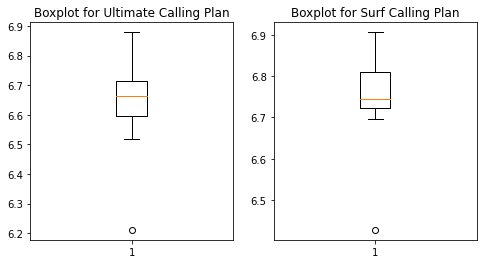

In [ ]:
# Plot a boxplot to visualize the distribution of the monthly call duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# Plot the boxplots for ultimate_internet_var
axes[0].boxplot(ultimate_mean)
axes[0].set_title('Boxplot for Ultimate Calling Plan')

# Plot the boxplots for surf_internet_var
axes[1].boxplot(surf_mean)
axes[1].set_title('Boxplot for Surf Calling Plan')

plt.show()



### Messages

I used the variables I had created before where I had filtered the data and grouped it. I then calculated the mean for total messages for each plan, as well as variance. As before, I used the means calculated above to plot a boxplot. The Ultimate plan has a higher average number of messages, but the Surf plan has greater variance.

month_x
1     15.500000
2     21.571429
3     20.250000
4     22.047619
5     32.103448
6     29.340426
7     32.830508
8     38.478873
9     37.895349
10    39.443396
11    38.606299
12    45.006623
Name: total_messages, dtype: float64
month_x
1     10.500000
2     12.000000
3     15.260870
4     17.400000
5     24.012987
6     25.298969
7     27.033058
8     28.777778
9     30.762887
10    33.839662
11    32.385159
12    38.600629
Name: total_messages, dtype: float64
month_x
1      313.666667
2      478.285714
3      654.386364
4      544.147619
5     1297.310345
6      857.620722
7      960.488019
8     1196.367404
9     1050.918331
10    1221.106289
11    1232.669166
12    1549.419956
Name: total_messages, dtype: float64
month_x
1      220.500000
2      386.000000
3      346.565217
4      501.591837
5      847.197198
6      914.920103
7      923.915565
8     1029.515528
9     1003.829496
10    1275.465708
11    1065.344034
12    1458.158612
Name: total_messages, dtype: float64


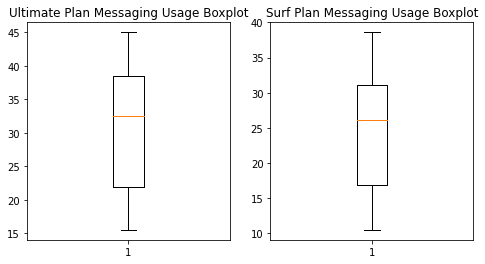

In [ ]:
# Compare the number of messages users of each plan tend to send each month
ultimate_messages = monthly_ultimate['total_messages'].mean()
surf_messages = monthly_surf['total_messages'].mean()
ultimate_messages_var = monthly_ultimate['total_messages'].var()
surf_messages_var = monthly_surf['total_messages'].var()

print(ultimate_messages)
print(surf_messages)
print(ultimate_messages_var)
print(surf_messages_var)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# Plot the boxplots for ultimate_internet_var
axes[0].boxplot(ultimate_messages)
axes[0].set_title('Ultimate Plan Messaging Usage Boxplot')

# Plot the boxplots for surf_internet_var
axes[1].boxplot(surf_messages)
axes[1].set_title('Surf Plan Messaging Usage Boxplot')

plt.show()

I used the variables I had created before where I had filtered the data and grouped it.I then totaled the total messages per month per plan and plotted both plans on a histogram. Once again, the Surf plan had a wider distribution.

<AxesSubplot:ylabel='Frequency'>

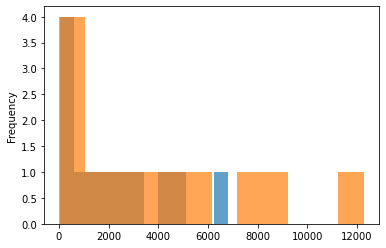

In [ ]:
ultimate_messages_total = monthly_ultimate['total_messages'].sum()
surf_messages_total = monthly_surf['total_messages'].sum()

ultimate_messages_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)

surf_messages_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)


I used the grp3 variable and grabbed the average of total messages for each month per plan. I then used that to create a bar chart. The average number of messages for both plans increased throughout the year for both plans. Overall, Ultimate plan users tend to use messaging more than Surf plan users.

<AxesSubplot:title={'center':'Average Number of Messages by Plan and Month'}, xlabel='Plan and Month', ylabel='Average Messages'>

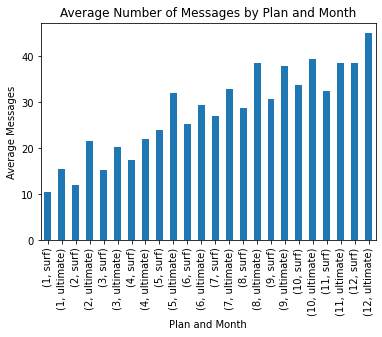

In [ ]:
avg_messages = grp3['total_messages'].mean()
avg_messages.plot(kind='bar',
                  x=['month_x', 'plan'],
                  y='total_messages',
                  title='Average Number of Messages by Plan and Month',
                  xlabel='Plan and Month',
                  ylabel='Average Messages')

### Internet

I used the internet traffic in mb for these calculations

I used the variables I had created before where I had filtered the data and grouped it. I then calculated the mean for internet traffic for each plan, as well as variance. As before, I used the means calculated above to plot a boxplot. The Ultimate plan has a higher average internet usage, but the Surf plan has greater variance.

month_x
1      6918.092500
2     17128.808571
3     18321.518333
4     16121.654762
5     16624.482414
6     15337.921064
7     16344.744407
8     17814.720141
9     16969.869535
10    17612.553396
11    17033.685354
12    18323.191854
Name: internet_traffic, dtype: float64
month_x
1      4874.860000
2     12178.843333
3     13345.440000
4     11984.203000
5     13936.354935
6     15301.529175
7     16783.600579
8     16795.331358
9     16591.431289
10    17311.335063
11    16339.254417
12    18132.469371
Name: internet_traffic, dtype: float64
month_x
1     1.639471e+07
2     3.764910e+07
3     1.403392e+08
4     8.842861e+07
5     5.679012e+07
6     7.201453e+07
7     6.841921e+07
8     6.044708e+07
9     4.933904e+07
10    5.699528e+07
11    5.758948e+07
12    6.188130e+07
Name: internet_traffic, dtype: float64
month_x
1     1.823995e+07
2     4.367296e+07
3     6.824556e+07
4     5.904494e+07
5     6.147653e+07
6     4.913339e+07
7     6.468655e+07
8     7.463649e+07
9     5.131665e

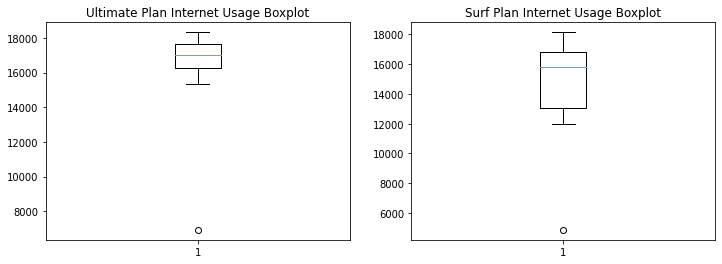

In [ ]:
#display(updated_user_info.head())
ultimate_internet = monthly_ultimate['internet_traffic'].mean()
surf_internet = monthly_surf['internet_traffic'].mean()
ultimate_internet_var = monthly_ultimate['internet_traffic'].var()
surf_internet_var = monthly_surf['internet_traffic'].var()

print(ultimate_internet)
print(surf_internet)
print(ultimate_internet_var)
print(surf_internet_var)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].boxplot(ultimate_internet)
axes[0].set_title('Ultimate Plan Internet Usage Boxplot')

axes[1].boxplot(surf_internet)
axes[1].set_title('Surf Plan Internet Usage Boxplot')


plt.show()

<AxesSubplot:ylabel='Frequency'>

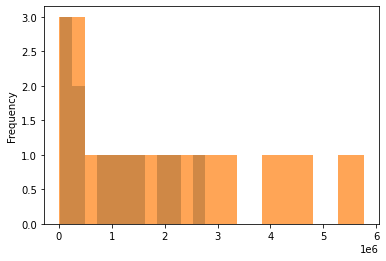

In [ ]:
ultimate_internet_total = monthly_ultimate['internet_traffic'].sum()
surf_internet_total = monthly_surf['internet_traffic'].sum()


ultimate_internet_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)

surf_internet_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)



<AxesSubplot:title={'center':'Average Internet Usage by Plan and Month'}, xlabel='Plan and Month', ylabel='Average Internet Usage'>

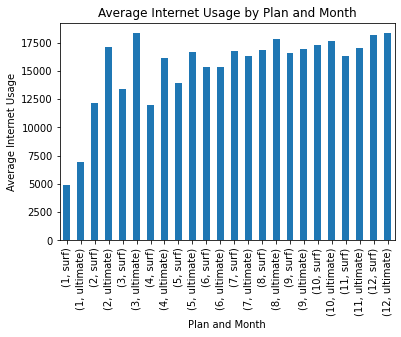

In [ ]:
avg_internet = grp3['internet_traffic'].mean()
avg_internet.plot(kind='bar',
                  x=['month_x', 'plan'],
                  y='internet_traffic',
                  title='Average Internet Usage by Plan and Month',
                  xlabel='Plan and Month',
                  ylabel='Average Internet Usage')

## Revenue

I used the variables I had created before where I had filtered the data and grouped it. I then calculated the mean for revenue for each plan, as well as variance. As before, I used the means calculated above to plot a boxplot. I am not entirely sure how to interpret the boxplots though.

month_x
1     70.000000
2     70.000000
3     70.000000
4     70.502630
5     70.000000
6     70.242766
7     70.685253
8     70.878126
9     70.191884
10    70.913195
11    70.503139
12    71.172784
Name: revenue, dtype: float64
month_x
1     20.000000
2     20.000000
3     20.000000
4     20.000000
5     20.095106
6     20.099313
7     20.350541
8     21.410189
9     20.045247
10    20.779917
11    20.346284
12    22.357099
Name: revenue, dtype: float64
month_x
1      0.000000
2      0.000000
3      0.000000
4      5.305375
5      0.000000
6      2.769950
7     13.767944
8     21.262207
9      2.212844
10    52.363611
11    19.239723
12    65.130564
Name: revenue, dtype: float64
month_x
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.696471
6       0.956724
7       5.791068
8     143.743465
9       0.258103
10     40.635500
11     12.211281
12    399.500760
Name: revenue, dtype: float64


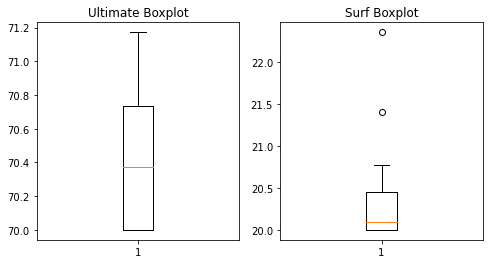

In [ ]:
ultimate_revenue_avg = monthly_ultimate['revenue'].mean()
surf_revenue_avg = monthly_surf['revenue'].mean()
ultimate_revenue_var = monthly_ultimate['revenue'].var()
surf_revenue_var = monthly_surf['revenue'].var()

print(ultimate_revenue_avg)
print(surf_revenue_avg)
print(ultimate_revenue_var)
print(surf_revenue_var)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].boxplot(ultimate_revenue_avg)
axes[0].set_title('Ultimate Boxplot')

axes[1].boxplot(surf_revenue_avg)
axes[1].set_title('Surf Boxplot')
plt.show()

I used the variables I had created before where I had filtered the data and grouped it.I then totaled the revenue per month per plan and plotted both plans on a histogram. The Ultimate plan had a wider distribution than the Surf plan in this case.

month_x
1       280.00000
2       490.00000
3       840.00000
4      1480.55523
5      2030.00000
6      3301.40998
7      4170.42992
8      5032.34695
9      6036.50204
10     7516.79866
11     8953.89865
12    10747.09042
Name: revenue, dtype: float64
month_x
1       40.00000
2      180.00000
3      460.00000
4     1000.00000
5     1547.32313
6     1949.63339
7     2462.41541
8     3468.45069
9     3888.77783
10    4924.84035
11    5757.99851
12    7109.55736
Name: revenue, dtype: float64


<AxesSubplot:ylabel='Frequency'>

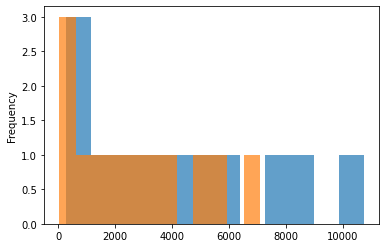

In [ ]:
ultimate_revenue_total = monthly_ultimate['revenue'].sum()
surf_revenue_total = monthly_surf['revenue'].sum()
print(ultimate_revenue_total)
print(surf_revenue_total)
ultimate_revenue_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)

surf_revenue_total.plot(kind='hist',
                     bins=12, 
                     alpha=0.7)


I used the grp3 variable and grabbed the average of revenue for each month per plan. I then used that to create a bar chart. The average revenue for both plans stayed very steady for each month. The Ultimate plan's average revenue was higher than the Surf plan's revenue.

<AxesSubplot:title={'center':'Average Revenue by Plan and Month'}, xlabel='Plan and Month', ylabel='Revenue'>

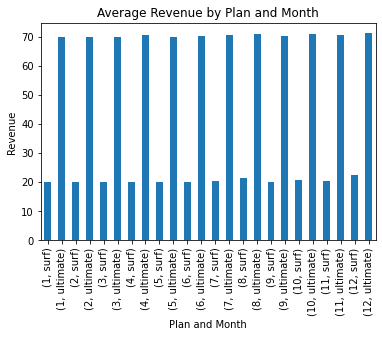

In [ ]:
avg_revenue = grp3['revenue'].mean()
avg_revenue.plot(kind='bar',
                  x=['month_x', 'plan'],
                  y='revenue',
                  title='Average Revenue by Plan and Month',
                  xlabel='Plan and Month',
                  ylabel='Revenue')

## Test statistical hypotheses

Null hypothesis: The average revenue of the Ultimate plan and the Surf plan are not different.
Alternative hypthosis: The average revenue of the Ultimate plan and the Surf plan are different.

I chose the test to test the equality between two population means (st.ttest_ind).

In [ ]:
# Test the hypotheses
alpha = .05

results = st.ttest_ind(updated_user_info[updated_user_info['plan'] == 'ultimate']['revenue'], updated_user_info[updated_user_info['plan'] == 'surf']['revenue'], equal_var=False)# your code: test the hypothesis that the means of the two independent populations are equal

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print(
        "We reject the null hypothesis: the difference in average revenue was significantly different."
    )
else:
    print(
        "We can't reject the null hypothesis: average revenue wasn't significantly different"
    )


p-value: 0.0
We reject the null hypothesis: the difference in average revenue was significantly different.


Null hypothesis: The average revenue in the NY-NJ area is not different than that of users in the other regions of the country.
Alternative hypthosis: The average revenue in the NY-NJ area is different than that of users in the other regions of the country.

I chose the test to test the equality between two population means (st.ttest_ind).

In [ ]:
# Test the hypotheses
alpha = .05

results = st.ttest_ind(updated_user_info[updated_user_info['region'] == 'NY-NJ']['revenue'], updated_user_info[updated_user_info['region'] == 'None']['revenue'], equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print(
        "We reject the null hypothesis: the difference in average revenue was significantly different."
    )
else:
    print(
        "We can't reject the null hypothesis: average revenue wasn't significantly different"
    )


p-value: 0.9671977211300125
We can't reject the null hypothesis: average revenue wasn't significantly different


# General conclusion
Overall, the Ultimate plan does pull in more revenue on average. Although the Ultimate plan allows for more texts, minutes, and internet usage, neither plan's users tend to go over their plan's limits. Average call time was similar for both plans, as was the average number of messages and the average internet usage. As a result, the Ultimate plan's higher monthly cost is more lucrative for Megaline. The NY/NJ region also did not show much difference in revenue compared to the rest of the country.
